In [1]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import keras 

# import numpy
# import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix


from keras import backend as K

Using TensorFlow backend.


# Main configs

In [2]:
loadFromMerged=True
loadFromIndexes= False
Mapper='S'
IgnoreEmpty= True
FoldID ="1"
Epoch_count=100
Batch_size=5000

# Load the data the old way


In [3]:
# x_data= [] 
# y_data= [] 


# with open( '../files/txt/seq_mapping_large.txt' ) as f:
#     x_data =   f.readlines()

# with open( '../files/txt/command_mapping_large.txt' ) as f:
#     y_data = f.readlines()
    
    
# x_data =[ np.array([ int(y) for y in x.strip().split( ' ') ])   for x in  x_data ] 
# y_data =[ x.strip().split(' ') for x in  y_data ] 


#  Load The Data The New Way

In [4]:
#  mapps the input records to a integer array for the input
def mapping_x( inp, includeDirection = False , TrimAt= 15 ):
    if includeDirection:
        return np.array([ int(x["packet_length"]) * (1 if x['packet_source']=='hub' else -1)  for x in inp ][:15])
    else:
        return np.array([ int(x["packet_length"])  for x in inp ][:15])

In [5]:
def mapping_y_service(inp):
    return np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_service_event(inp):
    return np.array(  list(set([ "%s-%s"%( x["event"] ,x["val"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_device_service(inp):
    return np.array(  list(set([ "%s & %s"%( x["device"] ,x["event"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_full(inp):
    return np.array(  list(set([ "%s & %s & %s"%( x["device"] ,x["event"], x['val'] ) for x in inp])) if (len(inp )>0) else ["none"] )


In [6]:
# this cleans the data removing emply nodes and turning the nodes into sarrays by calling the mapping function 
def clean_data( x_data, y_data , removeempty=True, Mapping='S'):
    cleans = [] 
    cleans = (sorted([ x for x in y_data if (removeempty and len(y_data[x]) > 0) or not removeempty  ] ))
    
    ret_x  = [x_data[x] for x in cleans]
    ret_y  = [y_data[x] for x in cleans] 
    
    print( len(y_data), len(cleans) )
    
    ret_x  = [ mapping_x(x) for x in ret_x ] 
    ret_y_s = [ mapping_y_service(y) for y in ret_y ]
    if Mapping=='S':
        ret_y  = [ mapping_y_service(y) for y in ret_y ]
    elif Mapping=='SE':
        ret_y  = [ mapping_y_service_event(y) for y in ret_y ]
    elif Mapping=='DS':
        ret_y  = [ mapping_y_device_service(y) for y in ret_y ]
    elif Mapping=='F':
        ret_y  = [ mapping_y_full(y) for y in ret_y ]
    return ret_x, ret_y, ret_y_s

In [7]:
x= []
y= []

x_test = []
y_test = []
y_test_service= []

x_train = {}
y_train = {}

test_names = []

add_to_trainig = [0,2]

if loadFromMerged:
    print("in load from merged")
    with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_hub_segments_final.json'  ) as f:
        y_data = json.load(f)

    with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_pcap_segments_final.json'  ) as f:
        x_data = json.load(f)
        
#     with open(  '../files/train/merged/hub_segments_2.json'  ) as f:
#         y_data = json.load(f)

#     with open(  '../files/train/merged/pcap_segments_2.json'  ) as f:
#         x_data = json.load(f)
  
    if len( y_data ) != len(x_data) :
        print( pick )
        
    
    x_train,y_train, y_train_service= clean_data( x_data, y_data, IgnoreEmpty , Mapping=Mapper )
    
    #     continue
#     if loadFromIndexes:
#         print("load from indexes")
#         with open("../files/train/merged/items_2_test-train_indexes.json")  as f:
#             index_info = json.load(f)


#         for i in index_info[FoldID]["test"]:
#             x_test[str(i)]=(x_data[str(i)] )
#             y_test[str(i)]=(y_data[str(i)] )

#         for i in index_info[FoldID]["train"]:
#             x_train[str(i)]=(  x_data[str(i)] )
#             y_train[str(i)]=(  y_data[str(i)] )
        
#         x_test_t,y_test_t= clean_data( x_test, y_test, IgnoreEmpty , Mapping=Mapper)
#         x_test.append(x_test_t)
#         y_test.append(y_test_t)
    #     else :
    print("loading from test files")
    test_files = sorted(glob.glob( '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/home*.json' ))
    print( "found files : " , len(test_files) )
    for pick  in test_files:
        fname  = os.path.basename(pick)
        test_names.append( fname )
        with open( os.path.join( '../files/train/test/test_homes/final_upload/usecases/hub_segments_final_final/', fname) ) as f:
            y_data_test = json.load(f)

        with open( os.path.join('../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/', fname) ) as f:
            x_data_test = json.load(f)


        t_x,t_y, t_z= clean_data( x_data_test, y_data_test, False , Mapping=Mapper )

#         if test_files.index(pick) in add_to_trainig:
#             x_test_t,y_test_t, y_test_service_t= clean_data( x_data_test, y_data_test, IgnoreEmpty , Mapping=Mapper)
#             x_train.extend(x_test_t)
#             y_train.extend(y_test_t)
#             y_train_service.extend(y_test_service_t)


        x_test.append(t_x)
        y_test.append(t_y)
        y_test_service.append(t_z)
            
#     x_test = x_data[ index_info["1"]["test"]  ]
#     y_test = y_data[ index_info["1"]["test"]  ]
    
#     x_train = x_data[ index_info["1"]["train"]  ]
#     y_train = y_data[ index_info["1"]["train"]  ]
#     x.extend(t_x)
#     y.extend(t_y)
else:
    for pick in sorted(glob.glob( '../files/train/hub_segments/*.json' )):
        fname  = os.path.basename(pick)
        test_names.append( fname )
        with open( os.path.join( '../files/train/hub_segments/', fname) ) as f:
            y_data = json.load(f)

        with open( os.path.join('../files/train/pcap_segments/', fname) ) as f:
            x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )
            continue

        t_x,t_y= clean_data( x_data, y_data, True )

        x.extend( t_x)
        y.extend(t_y)

x= np.array(x)
y= np.array(y)

# x_train = np.append( x_train, x_test[0] , axis=0)
# x_train = np.append( x_train, x_test[2] , axis=0)

# y_train = np.append( y_train, y_test[0] , axis=0)
# y_train = np.append( y_train, y_test[2] , axis=0)


len(x_train), len(y_test)

in load from merged
58958 57867
loading from test files
found files :  4
32069 32069
19968 19968
9109 9109
6404 6404


(57867, 4)

# Evaluate Mittigation Techniques

## Packet Padding

In [8]:
# days =[7,4,2,2]
# t_sum =0
# for ii in range(len(x_test)):
#     p = x_test[ii]
#     sizes = np.unique(np.concatenate(p), return_counts=True)
#     sums= 0 
#     for i in range(len(sizes[0])):
# #         print( "%d--> %d" % ( sizes[0][i], sizes[1][i] ) )
#         if  sizes[0][i] < 1000:
#             sums+= (1000-sizes[0][i] )* sizes[1][i]
#     t_sum +=(sums / days[ii] )/1000000 
#     print ( (sums / days[ii] )/1000000)
# print('--------')
# print(t_sum/4)    

In [9]:
# days =[7,4,2,2]
# t_sum =0
# d_sum = 0
# import math
# for ii in range(len(x_test)):

#     p = x_test[ii]
#     for i in p : 
#         t_sum += math.ceil(np.sum(i) / 2000)
#         d_sum+= np.sum( i )
# total_fixed  =  t_sum* 2000 / 15

# print ( total_fixed , d_sum, d_sum-t_sum*2000)

## Packet Insertion

In [10]:
# days =[7,4,2,2]
# t_sum =0
# for ii in range(len(x_test)):
#     p = x_test[ii]
#     sizes = np.unique(np.concatenate(p), return_counts=True)
#     sums= 0 
#     for i in range(len(sizes[0])):
# #         print( "%d--> %d" % ( sizes[0][i], sizes[1][i] ) )
#         if  sizes[0][i] < 1000:
#             sums+= (1000-sizes[0][i] )* sizes[1][i]
#     t_sum +=(sums / days[ii] )/1000000 
#     print ( (sums / days[ii] )/1000000)
# print('--------')
# print(t_sum/4)    

# sets the classes 

In [11]:
classes = sorted(list(np.unique(  np.concatenate( y_train  ))))
# print([ (i , classes[i]) for i in range( len(classes) ) ])

service_classes = sorted(list(np.unique(  np.concatenate( y_train_service  ))))
[ (i , service_classes[i]) for i in range( len(service_classes) ) ]

[(0, 'acceleration'),
 (1, 'activity'),
 (2, 'battery'),
 (3, 'button'),
 (4, 'colorTemperature'),
 (5, 'contact'),
 (6, 'level'),
 (7, 'lock'),
 (8, 'motion'),
 (9, 'ping'),
 (10, 'status'),
 (11, 'switch'),
 (12, 'temperature'),
 (13, 'threeAxis'),
 (14, 'unknown'),
 (15, 'water')]

## Filter the records by service/event types

In [12]:
def is_clean_event( inp, return_clean= True  ):
    return is_clean(inp, return_clean=return_clean, to_keep=[ 'no_logs', 'lock-unlocked', 'on/off-XXX', 'raw-XXX', 'read_attr_-_raw-XXX' ] )
#     if return_clean:
#         return  'no_logs' not in inp and 'lock-unlocked' not in inp and 'on/off-XXX' not in inp and 'raw-XXX' not in inp and 'read_attr_-_raw-XXX' not in inp
#     else:
#         return  'lock-locked' in inp or 'lock-unlocked'  in inp or 'on/off-XXX' in inp or  'raw-XXX' in inp  or 'read_attr_-_raw-XXX' in inp 
     
def is_clean_service( inp, return_clean= True  ):
    return is_clean(inp, to_keep=['no_logs','unknown', 'read_attr_-_raw'], return_clean=return_clean )
    
#     if return_clean:
#         return  'no_logs' not in inp and 'unknown' not in inp and 'read_attr_-_raw' not in inp #and 'ping' not in inp 
#     else:
#         return  'no_logs' in inp or  'unknown' in inp  or 'read_attr_-_raw' in inp #or 'ping' in inp 

def is_clean(inp, to_keep=[], return_clean=True):
    ret = False 
    
    for x  in to_keep:
        if x in inp:
            ret = True
            
    if not return_clean:
        ret = not ret
        
    return ret
    

choose services to keep : 

In [13]:
services_to_keep = ['button', 'colorTemperature', 'contact', 'lock', 'motion',"ping", 'switch','unknown'] 

find records which need change

In [14]:
train_indexes_to_change =  [ i for i in range(len(y_train)) if
              is_clean( y_train[i],to_keep=services_to_keep, return_clean=False) ] 

y_train = [ ['unknown'] if i in train_indexes_to_change else y_train[i] 
           for i in range(len(y_train)) ] 

for t_index in range(len(y_test)):
    test_indexes_to_change =  [ i for i in range(len(y_test[t_index])) if
                  is_clean( y_test[t_index][i],to_keep=services_to_keep, return_clean=False) ] 

    y_test[t_index] = [ ['unknown'] if i in test_indexes_to_change else y_test[t_index][i] 
               for i in range(len(y_test[t_index])) ] 

In [15]:
known_unknown_y_train = [ [1,0] if (len(x) == 1 and "unknown" in x) else [0,1]   for x in y_train ]

known_unknown_y_test= [] 

for i in range(len(y_test)):
    
    known_unknown_y_test.append( [ [1,0] if (len(x) == 1 and "unknown" in x) else [0,1]   for x in y_test[i] ])


remove classes that are ignored from the services list 

In [16]:
classes = services_to_keep

In [17]:
# toKeep = [ i for i in range(len(y_train)) if is_clean_event( y_train[i]) ] if Mapper=='SE' else [ i for i in range(len(y_train)) if is_clean_service( y_train[i]) ]
# x_train= [ x_train[i] for i in toKeep ]
# y_train= [ y_train[i] for i in toKeep ]


In [18]:
# for j in range(len(x_test)):
#     toChange= [ i for i in range(len(y_test[j])) if is_clean_service( y_test[j][i], False) ]
#     y_test[j] = [ (y_test[j][i] if i not in toChange else np.array( ['none'])) for i in range(len(y_test[j])) ]

In [19]:
# classes.remove('read_attr_-_raw-XXX')
# classes.remove('on/off-XXX')
# classes.remove('raw-XXX')
# classes.remove('lock-unlocked')
# classes.remove('lock-locked')


# classes.remove('read_attr_-_raw')
# classes.remove('on/off')
# classes.remove('raw')
# classes.remove('unknown')

# classes.remove('lock')
# # classes.remove('lock')


# classes.remove('switch-on')




## ===== end of unknown packet control=====

In [20]:
def pre_process_raw( x_data,y_data, dim_size = 128, zero_pad = False, normalize = False ,
                    classes=None, twoD= False, as_string=False ):
#  y data 
# """
# this functino is in charge of preprocessing the records , the sourc e json contains a lot of extra stuff, this function tailors
# the data and it fixes their lenghth
# """
    if classes is None:
        classes  = sorted(list(np.unique(  np.concatenate( y_data  ))))
    else :
        classes = sorted(classes)
    y_data_categorical = []  

    for x in y_data:
        temp = np.zeros( len(classes) )
        for y in x : 
            if y in classes:
                temp[ classes.index( y ) ] = 1
        y_data_categorical.append( temp )
    y_data_categorical = np.vstack(y_data_categorical)

#     x_data = np.array( x_data) / 1500.0
    
    x_data_temp = [] 
    
    if not zero_pad:
        if twoD:
            for x in x_data:
                temp = [] #list(x)
                lst = list(x)
                while dim_size**2 - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size**2:
                    temp.append( 0 )

                x_data_temp.append(np.array( temp).reshape(dim_size,dim_size))


            x_data_temp = np.array( x_data_temp )
            x_data_temp=x_data_temp.reshape(x_data_temp.shape+(1,))
        else: 
            temp = [] 
            lst = list(x)
            for x in x_data:
                temp = [] #list(x)
                lst = list(x)
                while dim_size - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size:
                    temp.append( 0 )
                
                x_data_temp.append(np.array( temp))
            
    else :
        x_data_temp = sequence.pad_sequences(x_data, maxlen=dim_size)
    
    
    
    if normalize:
        x_data_temp = np.array( x_data_temp) / (np.amax( x_data_temp) + 0.000000000001)
    else :
        x_data_temp = np.array(x_data_temp)
    
    
    if as_string:
        x_data_temp = [ ' '.join(x) for x in x_data_temp ]
    
    return x_data_temp ,y_data_categorical , classes

In [21]:
x,y,_=pre_process_raw( x_train, y_train , 15, zero_pad=True, normalize=True, classes=classes)

In [22]:
np.amax(x), np.amin(x)

(0.9999999999999997, 0.0)

# Model Evaluation Methods

In [23]:
def make_recall_shit( inp ):
    tp = inp[1][1]
    tn = inp[0][0]
    fp = inp[0][1] 
    fn = inp[1][0]
    
    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    
#     F= 2.0*( prec* recall )/ (prec+recall)
    F= 2.0*( tp)/ (2*tp + fp + fn)
    
    return acc, recall, prec, F

def acc_match( true, pred ):
    """
    returns exact mathc accuracy
    """
 
    return (len( [ x  for x  in  [np.sum(np.abs( true[i]- pred[i] )) for i in range(len(true))] if x  == 0]))*1.0 / len(true)


# def acc_none_zero ( true, pred ):
    

def acc_match_wierd( true, pred ):
    """
    returns exact mathc accuracy
    """
    level = 6 
    switch = 11
    threeAxis=13
    accel = 0 
    status=10
    contact=5
    
    counter  = 0 
    for i in range( len (true) ):
        if np.sum(np.abs( true[i]- pred[i] ))==0 :
            counter+=1
        else : 
            t_rec = np.array(list( pred[i]))
            
            if true[i][level]==1 and true[i][switch]==1 and t_rec[level]==1 :
                t_rec[switch]=1
            
            if true[i][threeAxis]==1 and true[i][accel]==1 and t_rec[threeAxis]==1:
                t_rec[accel] =1
            
            if true[i][status]==1 and true[i][contact]==1 and t_rec[status]==1:
                t_rec[contact]=1
#             print(t_rec , true[i])    
            if np.sum(np.abs( true[i]- t_rec ))==0 :
                counter+=1   
            
             
            
    
    return counter*1.0 / len(true)


def print_info(y_test, pred , classes , confidance=0.5 ):
    
    counts = np.sum( y_test.astype(int) , axis=0)
    
    pred[pred>=confidance] = 1
    pred[pred<confidance] = 0
    
#     acc_wierd  =acc_match_wierd(y_test, pred)
    
    conf= multilabel_confusion_matrix( y_test , pred.astype(int), labels= range(len(classes)))
    accs = [make_recall_shit(x) for x in conf]
    print( "%30s  %8s   %8s  %8s  %8s %8s %22s"  %( "Class","Accuracy", "Recall","Precision","F Score" , "Count", "TP/TN/FP/FN"))
    print( "------------------------------------------------------------------------" )
    
    for index in range(len(classes)):
        tp = conf[index][1][1]
        tn = conf[index][0][0]
        fp = conf[index][0][1] 
        fn = conf[index][1][0]
        print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %
             (classes[index],
              accs[index][0],
              accs[index][1],
              accs[index][2],
              accs[index][3],
              counts[index],
                  tp ,
                tn ,
                fp ,
                fn ))
    n_zeros_true = len([ x  for x  in  [np.sum(np.abs( y_test[i] )) for i in range(len(y_test))] if x  == 0]  )
    n_zeros_pred = len([ x  for x  in  [np.sum(np.abs( pred[i] )) for i in range(len(pred))] if x  == 0]  )
    
    accs = np.nan_to_num(accs)
    
    print ("------------------------------------------------------------------------")
    print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %
             ("AVERAGES",
              np.average( accs, axis=0)[0],
              np.average( accs, axis=0)[1],
              np.average( accs, axis=0)[2],
              np.average( accs, axis=0)[3],
              len(y_test),
                  0 ,
                0,
                0 ,
                0 ))
    
    print ( "Exact Match ACC : %.5f " % acc_match( y_test, pred )  )
#     print ( "Wierd Exact Match ACC : %.5f" % acc_wierd)
    print ( "Total Records : %d " % len(y_test)  )
    print ( "Total ZXeros in True : %d (%.3f)%%" % (n_zeros_true ,  n_zeros_true * 1.0/ len(y_test)  ))
    print ( "Total ZXeros in Test : %d (%.3f)%%" % (n_zeros_pred ,  n_zeros_pred * 1.0/ len(y_test)  ) )
    print ('=============================================================================')
    

In [24]:


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def make_readable_results ( inp , classes , conffidance=True):
    ret = [] 
    inp =inp.astype(int)
    for xx in range(len(inp)) :
        u = inp[xx]
        temp = []
        for j in range(len(u)) : 
            if u[j] >0:
                temp.append(classes[j])
        ret.append(temp)
    return ret


def makeReadable( model , data, gt, path , classes, x, confidance=0.5):
    #collect across multi models
    from keras.models import load_model
    x=[]
    for i in range(0,16):
        model=load_model('number'+str(i)+'.h5',custom_objects={'f1_perRow':f1_perRow,'f1_perClass':f1_perClass,'f1_loss_perRow':f1_loss_perRow,'f1_loss_perClass':f1_loss_perClass})
        x.append(model.predict(data))
    x=np.array(x)
    x=np.transpose(x)
    x=np.squeeze(x)
    print(x.shape)
        
        
    pred_temp  = x
    #pred_temp = model.predict(data)
    print_info(gt, x, classes , confidance=confidance)
#     print( len(classes ), len( pred_temp[0] ) )
#     xcc= make_readable_results(pred_temp , classes)
#     y_gt = make_readable_results( gt, classes )
#     temp_dic = {} 
#     for pick in range(len(xcc)): 
#         temp_dic[ pick +1 ] =  { 'seq': str(data[pick]),
#                                'pred': xcc[pick],
#                                 'true':y_gt[pick]
#                                }   

#     with open(path , 'w') as f:
#         json.dump(temp_dic , f, indent=4)


# def makeReadable( model , data, gt, path , classes, confidance=0.7, x):
#     pred_temp = model.predict( data)
#     print_info(gt, pred_temp, classes , confidance=confidance)
#     xcc= make_readable_results( pred_temp , classes )
#     temp_dic = {} 
#     for pick in range(len(xcc)): 
#         temp_dic[ pick +1 ] = xcc[pick]  

#     with open(path , 'w') as f:
#         json.dump(temp_dic , f, indent=4)

# Create the Model 

# Calcualte per class accuracy

# Random Forest baseline calc

preproicess the data 

In [25]:
dim_size= 50
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False, classes=classes)
rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=True, normalize=False, classes=classes) for i in range(len(x_test)) ] 

first stage RF will learn if it is a known or unknown instance 

In [26]:
from sklearn.ensemble import RandomForestClassifier

knownity_rf =  RandomForestClassifier(n_estimators=960, max_depth=9050,
                             random_state=0 )
knownity_rf_results = knownity_rf.fit(x_random_forest_train, known_unknown_y_train)


In [27]:
train_known_unknown_pred=knownity_rf.predict(x_random_forest_train)

In [28]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=knownity_rf.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( known_unknown_y_test[i]), rf_pred, ["unknown","known"])

==================HOME Case : home_muhammed_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.968      0.995     0.963     0.979     23896 23768/ 7271/  902/  128
                         known     0.968      0.890     0.983     0.934      8173  7271/23768/  128/  902
------------------------------------------------------------------------
                      AVERAGES     0.968      0.942     0.973     0.956     32069     0/    0/    0/    0
Exact Match ACC : 0.96788 
Total Records : 32069 
Total ZXeros in True : 0 (0.000)%
Total ZXeros in Test : 0 (0.000)%
==================HOME Case : home_os_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
   

In [29]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(rf_tests)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2]))

In [30]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=960, max_depth=9050,
                             random_state=0 )
t_hist = clf.fit(x_train_known, y_train_known)


In [31]:
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= clf.predict( rf_test_known[i][0])
    print_info( rf_test_known[i][1], rf_pred, classes)

==================HOME Case : home_muhammed_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     1.000      0.857     0.857     0.857         7     6/ 7391/    1/    1
              colorTemperature     1.000        nan       nan       nan         0     0/ 7399/    0/    0
                       contact     0.999      0.966     0.862     0.911        58    56/ 7332/    9/    2
                          lock     0.995      1.000     0.229     0.373        11    11/ 7351/   37/    0
                        motion     0.990      0.819     0.852     0.835       238   195/ 7127/   34/   43
                          ping     0.992      1.000     0.992     0.996      6952  6951/  390/   57/    1
                        switch     1.000      0.957     0.957     0.957        23    22/ 7375/    1/    1
                       unknown     0.983      0.897     0.961     0.928       90

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.999      0.000     0.000     0.000         1     0/ 2414/    1/    1
              colorTemperature     1.000        nan       nan       nan         0     0/ 2416/    0/    0
                       contact     0.997      0.942     0.925     0.933        52    49/ 2360/    4/    3
                          lock     0.992      0.923     0.400     0.558        13    12/ 2385/   18/    1
                        motion     0.978      0.654     0.500     0.567        52    34/ 2330/   34/   18
                          ping     0.990      1.000     0.989     0.994      2222  2222/  169/   25/    0
                        switch     0.998      1.000     0.375     0.545         3     3/ 2408/    5/    0
                       unknown     0.971      0.781     0.966     0.864       28

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


# LSTM 

In [33]:
# create the model
dim_size =15
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False,classes=classes)
_, y_s_lstm_processed_train ,_ =  pre_process_raw( x_train, y_train_service , dim_size, zero_pad=False, normalize=False,classes=service_classes)
# x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False,classes=classes)
lstm_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes) for i in range(len(x_test)) ] 
lstm_tests_services  = [ pre_process_raw( x_test[i], y_test_service[i] , dim_size, zero_pad=False, normalize=True, classes=service_classes) for i in range(len(x_test)) ] 



In [34]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_lstm_prossed_train = x_lstm_prossed_train[known_indexes_train]
y_lstm_prossed_train = y_lstm_prossed_train[known_indexes_train]

lstm_tests_known = [] 

for test_index in range(len(rf_tests)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    lstm_tests_known.append(  (lstm_tests[test_index][0][known_indexes], 
                            lstm_tests[test_index][1][known_indexes],
                            lstm_tests[test_index][2]))

In [35]:
# x_lstm_prossed_test2 = np.expand_dims(x_lstm_prossed_test,axis=1)
# x_lstm_prossed_train2 =np.expand_dims(x_lstm_prossed_train,axis=1)

for tt  in range( len(lstm_tests_known) ):
    lstm_tests_known[tt]= (lstm_tests_known[tt][0].reshape(len(lstm_tests_known[tt][0]),dim_size,1) ,
                           lstm_tests_known[tt][1],
                           lstm_tests_services[tt][1] )
# x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
x_lstm_prossed_train2 =x_lstm_prossed_train.reshape(len(x_lstm_prossed_train),dim_size,1)

# y_lstm_prossed_test2 = y_lstm_prossed_test.reshape(len(y_lstm_prossed_test),len(classes),1)
# y_lstm_prossed_train2 =y_lstm_prossed_train.reshape(len(y_lstm_prossed_train),len(classes),1)

In [40]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE
model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2




inputs  = Input( ( dim_size,1 ) )


out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(out)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(128, activation='relu')  (lstm_1)
lstm_1 =  Dense(128, activation='relu')(bi_d_1)
lstm_2 = Dense(128, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)





# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

dout_1  = Dropout(0.1)(lstm_raw_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_3  = Dropout(0.2)(dense_1)





out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')

dens_out_1 = Dense( 128, activation='relu' )(out_new)
dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

 
weights = [
1.0/(57.0 / len(y_train)),
1.0/(19.0 / len(y_train)),
1.0/(7.0 / len(y_train)),
1.0/(14.0 / len(y_train)),
1.0/(6.0 / len(y_train)),
1.0/(176.0 / len(y_train)),
1.0/(27.0 / len(y_train)),
1.0/(35.0 / len(y_train)),
1.0/(371.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
1.0/(4842.0 / len(y_train)),
1.0/(119.0 / len(y_train)),
1.0/(21.0 / len(y_train)),
1.0/(1168.0 / len(y_train)),
1.0/(63.0 / len(y_train)),
1.0/(13305.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
]
    


# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 15, 1)        0                                            
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 15, 128)      512         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 15, 128)      512         conv1d_19[0][0]                  
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 15, 128)      0           batch_normalization_10[0][0]     
__________________________________________________________________________________________________
conv1d_17 

Epoch 1/100
24427/24427 [==============================] - 5s 222us/step - loss: 41.0789 - f1_perRow: 0.1408 - f1_perClass: 0.2438 - acc: 0.4151
Epoch 2/100
24427/24427 [==============================] - 1s 37us/step - loss: 23.1859 - f1_perRow: 0.2311 - f1_perClass: 0.5514 - acc: 0.8173
Epoch 3/100
24427/24427 [==============================] - 1s 36us/step - loss: 12.3100 - f1_perRow: 0.3912 - f1_perClass: 0.8365 - acc: 0.8173
Epoch 4/100
24427/24427 [==============================] - 1s 36us/step - loss: 10.8088 - f1_perRow: 0.4712 - f1_perClass: 0.8315 - acc: 0.8173
Epoch 5/100
24427/24427 [==============================] - 1s 35us/step - loss: 9.2991 - f1_perRow: 0.5437 - f1_perClass: 0.8641 - acc: 0.8173
Epoch 6/100
24427/24427 [==============================] - 1s 35us/step - loss: 8.2308 - f1_perRow: 0.5894 - f1_perClass: 0.8674 - acc: 0.8173
Epoch 7/100
24427/24427 [==============================] - 1s 36us/step - loss: 7.7272 - f1_perRow: 0.6167 - f1_perClass: 0.8756 - acc: 0

24427/24427 [==============================] - 1s 36us/step - loss: 4.8123 - f1_perRow: 0.8425 - f1_perClass: 0.9255 - acc: 0.8174
Epoch 58/100
24427/24427 [==============================] - 1s 36us/step - loss: 4.8077 - f1_perRow: 0.8444 - f1_perClass: 0.9259 - acc: 0.8174
Epoch 59/100
24427/24427 [==============================] - 1s 36us/step - loss: 4.8009 - f1_perRow: 0.8436 - f1_perClass: 0.9259 - acc: 0.8174
Epoch 60/100
24427/24427 [==============================] - 1s 36us/step - loss: 4.7821 - f1_perRow: 0.8470 - f1_perClass: 0.9262 - acc: 0.8174
Epoch 61/100
24427/24427 [==============================] - 1s 36us/step - loss: 4.7791 - f1_perRow: 0.8463 - f1_perClass: 0.9261 - acc: 0.8174
Epoch 62/100
24427/24427 [==============================] - 1s 36us/step - loss: 4.7766 - f1_perRow: 0.8453 - f1_perClass: 0.9259 - acc: 0.8175
Epoch 63/100
24427/24427 [==============================] - 1s 36us/step - loss: 4.7761 - f1_perRow: 0.8480 - f1_perClass: 0.9262 - acc: 0.8175
Epoch

In [43]:
# print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=200, batch_size=12500, shuffle=True, callbacks=callbacks_list)



Epoch 1/200
24427/24427 [==============================] - 1s 37us/step - loss: 4.7279 - f1_perRow: 0.8576 - f1_perClass: 0.9273 - acc: 0.8188
Epoch 2/200
24427/24427 [==============================] - 1s 36us/step - loss: 4.7058 - f1_perRow: 0.8533 - f1_perClass: 0.9268 - acc: 0.8184
Epoch 3/200
24427/24427 [==============================] - 1s 35us/step - loss: 4.7014 - f1_perRow: 0.8500 - f1_perClass: 0.9268 - acc: 0.8191
Epoch 4/200
24427/24427 [==============================] - 1s 36us/step - loss: 4.7062 - f1_perRow: 0.8528 - f1_perClass: 0.9272 - acc: 0.8193
Epoch 5/200
24427/24427 [==============================] - 1s 35us/step - loss: 4.7033 - f1_perRow: 0.8542 - f1_perClass: 0.9271 - acc: 0.8195
Epoch 6/200
24427/24427 [==============================] - 1s 36us/step - loss: 4.6969 - f1_perRow: 0.8547 - f1_perClass: 0.9272 - acc: 0.8192
Epoch 7/200
24427/24427 [==============================] - 1s 36us/step - loss: 4.7076 - f1_perRow: 0.8545 - f1_perClass: 0.9270 - acc: 0.8194

24427/24427 [==============================] - 1s 36us/step - loss: 4.6479 - f1_perRow: 0.8625 - f1_perClass: 0.9280 - acc: 0.8215
Epoch 58/200
24427/24427 [==============================] - 1s 36us/step - loss: 4.6481 - f1_perRow: 0.8620 - f1_perClass: 0.9280 - acc: 0.8213
Epoch 59/200
24427/24427 [==============================] - 1s 36us/step - loss: 4.6517 - f1_perRow: 0.8585 - f1_perClass: 0.9277 - acc: 0.8220
Epoch 60/200
24427/24427 [==============================] - 1s 36us/step - loss: 4.6820 - f1_perRow: 0.8565 - f1_perClass: 0.9275 - acc: 0.8218
Epoch 61/200
24427/24427 [==============================] - 1s 36us/step - loss: 4.7629 - f1_perRow: 0.8482 - f1_perClass: 0.9263 - acc: 0.8367
Epoch 62/200
24427/24427 [==============================] - 1s 36us/step - loss: 5.6288 - f1_perRow: 0.7851 - f1_perClass: 0.9196 - acc: 0.8549
Epoch 63/200
24427/24427 [==============================] - 1s 37us/step - loss: 7.8786 - f1_perRow: 0.6857 - f1_perClass: 0.8990 - acc: 0.8405
Epoch

24427/24427 [==============================] - 1s 36us/step - loss: 3.2604 - f1_perRow: 0.8309 - f1_perClass: 0.9579 - acc: 0.9231
Epoch 114/200
24427/24427 [==============================] - 1s 36us/step - loss: 3.2515 - f1_perRow: 0.8326 - f1_perClass: 0.9587 - acc: 0.9236
Epoch 115/200
24427/24427 [==============================] - 1s 38us/step - loss: 3.2036 - f1_perRow: 0.8373 - f1_perClass: 0.9597 - acc: 0.9257
Epoch 116/200
24427/24427 [==============================] - 1s 38us/step - loss: 3.1905 - f1_perRow: 0.8329 - f1_perClass: 0.9589 - acc: 0.9266
Epoch 117/200
24427/24427 [==============================] - 1s 36us/step - loss: 3.1778 - f1_perRow: 0.8311 - f1_perClass: 0.9593 - acc: 0.9264
Epoch 118/200
24427/24427 [==============================] - 1s 40us/step - loss: 3.1659 - f1_perRow: 0.8299 - f1_perClass: 0.9587 - acc: 0.9300
Epoch 119/200
24427/24427 [==============================] - 1s 38us/step - loss: 3.1622 - f1_perRow: 0.8326 - f1_perClass: 0.9600 - acc: 0.9342

24427/24427 [==============================] - 1s 40us/step - loss: 2.4633 - f1_perRow: 0.8357 - f1_perClass: 0.9651 - acc: 0.9809
Epoch 170/200
24427/24427 [==============================] - 1s 41us/step - loss: 2.4551 - f1_perRow: 0.8358 - f1_perClass: 0.9639 - acc: 0.9811
Epoch 171/200
24427/24427 [==============================] - 1s 41us/step - loss: 2.3706 - f1_perRow: 0.8619 - f1_perClass: 0.9683 - acc: 0.9818
Epoch 172/200
24427/24427 [==============================] - 1s 41us/step - loss: 2.3839 - f1_perRow: 0.8631 - f1_perClass: 0.9694 - acc: 0.9825
Epoch 173/200
24427/24427 [==============================] - 1s 38us/step - loss: 2.3659 - f1_perRow: 0.8581 - f1_perClass: 0.9702 - acc: 0.9821
Epoch 174/200
24427/24427 [==============================] - 1s 38us/step - loss: 2.3703 - f1_perRow: 0.8555 - f1_perClass: 0.9700 - acc: 0.9813
Epoch 175/200
24427/24427 [==============================] - 1s 39us/step - loss: 2.3713 - f1_perRow: 0.8559 - f1_perClass: 0.9702 - acc: 0.9810

In [47]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests_known[i][1], lstm_pred, classes , confidance=0.3)

==================HOME Case : home_muhammed_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.981      0.714     0.035     0.068         7     5/ 7256/  136/    2
              colorTemperature     1.000        nan       nan       nan         0     0/ 7399/    0/    0
                       contact     0.997      0.983     0.704     0.820        58    57/ 7317/   24/    1
                          lock     0.995      0.909     0.217     0.351        11    10/ 7352/   36/    1
                        motion     0.987      0.815     0.792     0.803       238   194/ 7110/   51/   44
                          ping     0.991      1.000     0.991     0.995      6952  6950/  383/   64/    2
                        switch     0.999      0.913     0.840     0.875        23    21/ 7372/    4/    2
                       unknown     0.987      0.935     0.955     0.945       90

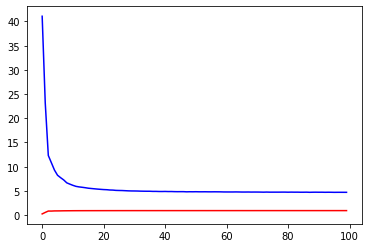

In [42]:
plt.plot(hist2.history['f1_perClass'], c='red')
plt.plot(hist2.history['loss'], c='blue')

In [ ]:
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.5)

In [ ]:
plt.plot(hist2.history['f1_perClass'], c='red')
plt.plot(hist2.history['loss'], c='blue')

In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )



# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(128, activation='relu')  (lstm_1)
lstm_1 =  Dense(128, activation='relu')(bi_d_1)
lstm_2 = Dense(128, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)







dens_out_3 = Dense( 128, activation='relu' )(dout_2)


# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


#model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=1000, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )






out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)


dens_out_3 = Dense( 128, activation='relu' )(fl_out_cnn)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1)) 

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))



inputs  = Input( ( dim_size,1 ) )







# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

dout_1  = Dropout(0.1)(lstm_raw_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_3  = Dropout(0.2)(dense_1)





out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
out_new = concatenate( [ fl_out_cnn,dout_3] , name='mergerguy')

dens_out_1 = Dense( 128, activation='relu' )(out_new)
dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)



service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(dens_out_3)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perClass ,
#     "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
#     "service_output": 20
}
 


model2.compile(loss=losses, loss_weights=lossWeights, optimizer=keras.optimizers.Adam(lr=1e-6  ), metrics=[f1_perRow,f1_perClass,'acc'])


In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )



# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(32 ,  recurrent_dropout=0.3, return_sequences=True)(inputs)
lstm_2 = LSTM(32 ,  recurrent_dropout=0.3, return_sequences=True)(lstm_1)

lstm_2=Flatten()(lstm_2)
lstm_2 = Dense(256, activation='relu')(lstm_2)




service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(lstm_2)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())

hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)



In [ ]:
#split model
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

#splitting data
X=x_lstm_prossed_train2
y=y_lstm_prossed_train
a,b,c,d,e,f,g,h,ii,jj,k,l,m,n,o,p=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
print(len(y_lstm_prossed_train[0]))
for i in range(0,len(y_lstm_prossed_train)):
    a.append(y_lstm_prossed_train[i][0])
    b.append(y_lstm_prossed_train[i][1])
    c.append(y_lstm_prossed_train[i][2])
    d.append(y_lstm_prossed_train[i][3])
    e.append(y_lstm_prossed_train[i][4])
    f.append(y_lstm_prossed_train[i][5])
    g.append(y_lstm_prossed_train[i][6])
    h.append(y_lstm_prossed_train[i][7])
    ii.append(y_lstm_prossed_train[i][8])
    jj.append(y_lstm_prossed_train[i][9])
    k.append(y_lstm_prossed_train[i][10])
    l.append(y_lstm_prossed_train[i][11])
    m.append(y_lstm_prossed_train[i][12])
    n.append(y_lstm_prossed_train[i][13])
    o.append(y_lstm_prossed_train[i][14])
    p.append(y_lstm_prossed_train[i][15])
    
zzzz=[]    
zzzz.append(np.array(a))
zzzz.append(np.array(b))
zzzz.append(np.array(c))
zzzz.append(np.array(d))
zzzz.append(np.array(e))
zzzz.append(np.array(f))
zzzz.append(np.array(g))
zzzz.append(np.array(h))
zzzz.append(np.array(ii))
zzzz.append(np.array(jj))
zzzz.append(np.array(k))
zzzz.append(np.array(l))
zzzz.append(np.array(m))
zzzz.append(np.array(n))
zzzz.append(np.array(o))
zzzz.append(np.array(p))


for i in range(0,16):
    
    
        
        
    


    inputs  = Input( ( dim_size,1 ) )


    out = Conv1D(128,3,padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
    lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(out)
    # lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

    bi_d_1 =Dense(128, activation='relu')  (lstm_1)
    lstm_1 =  Dense(128, activation='relu')(bi_d_1)
    lstm_2 = Dense(128, activation='relu')(lstm_1)



    # td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
    # dout_1  = Dropout(0.1)(td_1)
    dout_1  = Dropout(0.1)(lstm_2)
    flt_1   = Flatten()(dout_1)
    dense_1 = Dense(128, activation='relu')(flt_1)
    dout_2  = Dropout(0.2)(dense_1)





    # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
    lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
    # lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

    bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
    lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
    lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

    dout_1  = Dropout(0.1)(lstm_raw_2)
    flt_1   = Flatten()(dout_1)
    dense_1 = Dense(128, activation='relu')(flt_1)
    dout_3  = Dropout(0.2)(dense_1)





    out = Conv1D(128,3,padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling')(out)


    out = Conv1D(128,3,padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


    out = Conv1D(128,3,padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling')(out)



    # fl_out_1 = Flatten()(dout_2)

    fl_out_cnn = Flatten()(out)

    # out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
    out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')

    dens_out_1 = Dense( 128, activation='relu' )(out_new)
    dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
    dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

    # fl2  = Flatten()(out_new)

    out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

    toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
    toService_1 = Dense( 130, name="to_service2" )(toService_1)

    service_output = Dense(1, activation="sigmoid", name = 'service_output')(toService_1)


    losses = {
    #     "service_output": f1_loss_perClass ,
        "service_output": f1_loss_perRow ,
        "service_output": "binary_crossentropy",
    }
    lossWeights = {#"service_output": 20,
                   "service_output": 30.0 ,
        "service_output": 20}




    model2 = Model(inputs=[inputs], outputs=[service_output])
    model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
    # model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    hist2 = model2.fit(x_lstm_prossed_train2, zzzz[i], epochs=200, batch_size=12500, shuffle=True, callbacks=callbacks_list)
    model2.save('number'+str(i)+'.h5')


In [ ]:
# model2.compile(loss=losses,loss_weights=lossWeights, optimizer=keras.optimizers.Adam(lr=5e-5  ), metrics=[f1_perRow,f1_perClass,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=16500, shuffle=True)


In [ ]:
model2.compile(loss=f1_loss, optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=[f1,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=7500, shuffle=True)

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])

In [ ]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=3500, shuffle=True)

In [ ]:
model2.save( "LSTM-sigmoid-withRemovedClasses" )

In [ ]:
plt.plot(hist2.history['loss'], c='red')
plt.plot(hist2.history['acc'], c='blue')

In [ ]:
plt.plot(hist2.history['loss'], c='red')
# plt.plot(hist2.history['acc'], c='blue')

In [ ]:
from keras.utils import plot_model
plot_model(model2, to_file='model.png')

In [ ]:
# from keras.models import load_model
# model2=load_model( "LSTM_withSigmoid_LargeData_F1_E100_B500_MSE_False"  
#            )

In [ ]:
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    makeReadable( classes=classes, confidance=0.5,data=lstm_tests[i][0],gt=lstm_tests[i][1],model=model2,path=test_names[i],x=lstm_tests[i][0])
    
#     lstm_pred= model2.predict( lstm_tests[i][0])
    


# ------------- do not go any further :) ------

In [ ]:
lstm_pred= model2.predict( lstm_tests[i][0])

In [ ]:
lstm_pred= model2.predict( lstm_tests[1][0])
lstm_pred__ = np.array(list(lstm_pred))

In [ ]:
lstm_pred__ = np.array(list(lstm_pred))
print_info( lstm_tests[1][1], lstm_pred__, classes , confidance=0.43)

In [ ]:
# for i in [1] :
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.5)
    

In [ ]:
for i in [1] :
# for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.992)
    



In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test2)


In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.60)

In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
print_info(y_lstm_prossed_train, y_lstm_prossed_train, classes, confidance=0.60)

In [ ]:
[x for x  in lstm_pred  if  np.sum(x) > 0 ]

In [ ]:
model2.save( "LSTM_withSigmoid_LargeData_F%s_E%d_B%d_M%s_%r" %
            (
            FoldID,
                Epoch_count,
                Batch_size,
                Mapper,
                IgnoreEmpty
            ) 
           )

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )

In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
# x_train_muhammed,y_train_muhammed, classes = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False)
# x_test_muhammed,y_test_muhammed, classes = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
pred[:10]

In [ ]:
print_info(y_lstm_prossed_test, pred, classes)

In [ ]:
pred[0]

In [ ]:
len( y_lstm_prossed_train[0] )

In [ ]:
dim_size =160
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False,classes=classes)
x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False,classes=classes)

In [ ]:
len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1]), len(y_lstm_prossed_test  ) , len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1])/len(y_lstm_prossed_test  ) *1.0

In [ ]:
[ x for x  in  pred if np.sum(x) > 1]

In [ ]:
len(y_lstm_prossed_test)

In [ ]:
def do_for_raun( pred   ):
    pp = pred
    pp[pp>=0.5] = 1
    pp[pp<0.5] = 0
    return pp

In [ ]:
len([x for x in pred if np.sum( do_for_raun(x) )==0 ])

In [ ]:
len([x for x in pred if  do_for_raun(x)[20] ==1 or do_for_raun(x)[21] ==1 ])

In [ ]:

# np.save("../files/muhammed/x_train.json" , x_train_muhammed)
# np.save("../files/muhammed/y_train.json", )


# np.save( "../files/muhammed/x_train.json", x_train_muhammed )
# np.save("../files/muhammed/y_train.json",  y_train_muhammed )
# np.save( "../files/muhammed/x_test.json",x_test_muhammed )
# np.save( "../files/muhammed/y_test.json",y_test_muhammed )
# np.save( "../files/muhammed/classes.json",  classes )


In [ ]:
len(x_lstm_prossed_test) + len(x_lstm_prossed_train)